In [1]:
# Required imports

from tfscreen.fitting import (
    run_least_squares,
    predict_with_error
)

from tfscreen.process_raw import od600_to_cfu

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import yaml


# Calibration protocol

Or goal was to construct an empirical function that allowed us to plug in OD600 and obtain CFU/mL. To build this, we took the same samples and carefully measured both OD600 and colony forming units via serial plate dilution. We also propagated uncertainty through the analysis, allowing us estimate CFU/mL uncertainty as well. 

## Calibrate cfu/mL measurement using plate reader OD600

### Experimental setup 

+ All experiments done using keio cells growing in LB (matching our data collection).
+ Data were collected on a SpectraMax i3 plate reader with clear 96 well plates and 200 uL of sample. 

### Measurement

Before fitting a model to our data, we needed to estimate uncertainties to properly weight our regression. We have two sources of experimental error in this experiment: uncertainty in our measurement of the OD600 ($\sigma_{OD600}$) and uncertainty in our measured cfu/mL $(\sigma_{cfu})$. 

We can estimate $\sigma_{OD600}$ by taking a culture and measuring its OD600 multiple times. We did ten technical replicates of this experiment for a 1:3 serial dilution covering our OD600 range of interest. (Each technical replicate involved pipetting from the cell culture tube, transfering into a 96-well plate, and then measuring the sample. This directly matches the process we used in our production experiments). The data from this experiment are in the file "20250917-serial-dilution-of-keio-cells-with-10x-technical-triplicate-od600.xlsx." We found this error was 0.9-2.0%, increasing slightly with increasing OD600. We propagated the maximum value of 2.0% through the remainder of the analysis. 

This dilution protocol also allowed us to find the detection threshold for OD600 on this plate reader: 0.096. We defined this as midway between the values of lowest two points in our dataset that differed more than this error. 

There are two sources of uncertainty in our measurement tof $(\sigma_{cfu})$. The first is counting error. We modeled this as a Poisson process: 

$$\sigma^{2}_{counts} = \frac{1}{C}$$

where $C$ is the number of colony counts. The second form of uncertainty in due do random error in our pipetting. If we have $N$ dilution steps, followed by a plating step, we have $1 + N$ events. If they are independent and share the same percent error, we get:

$$\sigma^{2}_{pipette} = (1 + N) \times (\%_{err})^2$$

Combining these, we can estimate our total variance in our estimate of CFU/mL $(\sigma^{2}_{cfu})$ as:

$$\sigma^{2}_{cfu} = \sigma^{2}_{counts} + \sigma^{2}_{pipette} = \frac{1}{C} + (1 + N) \times (\%_{err})^2$$

We independently measured cfu/mL and OD600 for 19 samples spanning OD600 0.11 to 0.59. We found the average error in CFU/mL was 10.3%. The data describing this are in "20250919_od600-vs-cfu-per-mL-by-plate-counting.xlsx". 

### Polynomial constructions

We fit a second order polynomial in OD600 to CFU/mL. This uses the measurement with lower uncertainty (OD600) as the independent variable in regression. We regressed the polynomial coefficients with weighted nonlinear least squares, weighted by the inverse variance in each CFU/mL measurement. 

When using the polynomial to estimate cfu/mL, there are two sources of error: 

1. Uncertainty in our OD600 measurement ($\sigma_{cfu,OD600}$).
2. Uncertainty in the mapping between OD600 and cfu/mL from our fit ($\sigma_{cfu,fit}$).

The total variance is thus:

$$\sigma_{cfu}^{2}=\sigma_{OD600}^{2} + \sigma_{cfu,fit}^{2}$$

We already have an estimate of from above: $\sigma_{OD600} = 0.02$. 

The mapping error itself has two components. The first comes about because the training data did not perfectly constrain the fit parameters. We can estimate the uncertainty in our model output based on our parameter uncertainty using standard methods from non-linear regression:  

$$\sigma_{cfu,fit}^{2} \approx\boldsymbol{J}_{p}\boldsymbol{C}_{p}\boldsymbol{J}_{p}^{T}$$

where $\boldsymbol{J}_{p}$ is the Jacobian (numerically approximated during the regression) and $\boldsymbol{C}_{p}$ contains the values of OD600 at which we estimate cfu/mL. 

The second mapping error comes about beceause the curve is nonlinear. This means the propagation of $\sigma_{OD600}$ through the curve is not constant: the steeper the curve, the higher our output uncertainty. We can describe this dependence by:

$$\sigma^{2}_{OD600,propagated} = \sigma_{OD600}^{2}\left(\frac{\partial [cfu/mL]}{\partial [OD600]}\right)^{2}$$

Because we fit a polynomial of the form $cfu/mL \sim a + b\times OD600 + c\times (OD600)^2$, the partial derivative is $b + 2c\times OD600$. The total uncertainty in our estimated CFU/mL given a measurement of $OD_{600}$ is thus:

$$\sigma_{cfu} = \sqrt{\boldsymbol{J}_{p}\boldsymbol{C}_{p}\boldsymbol{J}_{p}^{T}+(0.02 \times OD600)^{2} \times \left (b + 2c\times OD600 \right)^2}$$

To make this analysis practical, we calculated $\boldsymbol{J}_{p}\boldsymbol{C}_{p}\boldsymbol{J}_{p}^{T}$ as a function of OD600, then fit another second order polynomial (with coefficients $p$, $q$, and $r$) to this curve. This allows us to rapidly calculate $\boldsymbol{J}_{p}\boldsymbol{C}_{p}\boldsymbol{J}_{p}^{T}$ for any value of $OD600$. 

### Final model

Our final protocol allows us to estimate cfu/mL and $\sigma_{cfu}$ with the following:

$$cfu/mL \sim a + b\times OD600 + c^{2} \times OD600$$
$$\sigma_{cfu} \sim \sqrt{(p + q\times OD600 + r\times(OD600)^2)+(0.02 \times OD600)^{2} \times \left (b + 2c\times OD600 \right)^2}$$

where $a = -5388603.36438282$, $b = 66683325.953339$, $c = 38292706.79524336$, $p = 801108.73371897$, $q = -5133635.54769162$, and $r = 13418613.55590658$. 

If $OD600 < 0.096$ it is below our detection limit. 




# Perform a calibration

This walks through our entire calibration. This should allow people to reproduce our results, as well as calibrate for their own experimental setups. 

## Set up the calculation

Specify inputs. Over this notebook, we will populate `CALIBRATION_CONSTANTS` and will then save it to `CALIBRATION_OUTPUT_FILE`. This can then be used to translate experimental OD600s to cfu/mL via the `tfscreen.process_raw.od600_to_cfu` function. 

In [2]:
# This will be populated over this spreadsheet and ultimately written out as a
# calibration yaml. 
CALIBRATION_CONSTANTS = {}

# Estimated error in the pipettor used for the serial dilutions. 
PIPETTE_PCT_ERROR = 0.02

# technical replicate OD600 measurement spreadsheet. These were 10x
# technical replicates, covering the process of grabbing a tube from the shaker,
# swirling, pipetting into a plate, and then measuring on the plate reader. We
# did 1/3 serial dilutions of each sample. 
TECH_REP_SPREADHSEET = "2025-09-17_od600-serial-dilution-of-keio-cells-with-10x-technical-replicate.xlsx"

# spreadsheet holding plate cfu vs plate read od600. This must also include
# the total dilution and number of dilution steps and/or plating steps that
# were used to obtain the cfu. (this is required for propagating pipetting
# uncertainty). 
OD600_CFU_SPREADSHEET = "2025-09-19_od600-vs-cfu-per-mL-by-plate-counting.xlsx"

# Store output file here
CALIBRATION_OUTPUT_FILE = "od600_to_cfu.yaml"


In [3]:
# Read technical replicates and add overall dilution as the index column
tech_rep_df = pd.read_excel(TECH_REP_SPREADHSEET,
                            sheet_name="1-3dilution",
                            header=None,
                            names=[f"rep{i}" for i in range(10)])
tech_rep_df["dilution"] = 1/(3**(np.arange(len(tech_rep_df)))) 
tech_rep_df = tech_rep_df.set_index("dilution")
tech_rep_df

,rep0,rep1,rep2,rep3,rep4,rep5,rep6,rep7,rep8,rep9
dilution,,,,,,,,,,
1.000000,0.5993,0.6060,0.5971,0.5928,0.5954,0.5929,0.5895,0.5906,0.5996,0.5868
0.333333,0.2733,0.2721,0.2705,0.2671,0.2670,0.2660,0.2673,0.2661,0.2655,0.2590
0.111111,0.1505,0.1503,0.1483,0.1471,0.1461,0.1429,0.1430,0.1434,0.1442,0.1431
0.037037,0.1090,0.1113,0.1085,0.1094,0.1111,0.1076,0.1081,0.1106,0.1096,0.1100
0.012346,0.0983,0.0989,0.0969,0.0972,0.0994,0.0960,0.0966,0.0979,0.1003,0.1003
0.004115,0.0949,0.0934,0.0938,0.0933,0.0932,0.0929,0.0927,0.0928,0.0930,0.0928


In [4]:
# Read cfu vs. od600 spreadsheet
pc_df = pd.read_excel(OD600_CFU_SPREADSHEET)
pc_df

,Plate Number,CFU,Volume_mL,Dilution,CFU_per_mL,OD600 plate reader,replicate,num_dilutions,plating_steps
0,5,485,0.1,100000,485000000,0.5880,20250213,5,1
1,6,385,0.1,100000,385000000,0.5299,20250213,5,1
2,7,315,0.1,100000,315000000,0.4499,20250213,5,1
3,8,244,0.1,100000,244000000,0.3857,20250213,5,1
4,9,198,0.1,100000,198000000,0.3386,20250213,5,1
5,10,161,0.1,100000,161000000,0.2941,20250213,5,1
6,11,146,0.1,100000,146000000,0.2588,20250213,5,1
7,12,101,0.1,100000,101000000,0.2267,20250213,5,1
8,13,75,0.1,100000,75000000,0.1830,20250213,5,1
9,14,68,0.1,100000,68000000,0.1680,20250213,5,1


#### Define the polynomial we will fit

In [5]:

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def simple_poly(params: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Evaluate a polynomial at specific x values.

    The polynomial is defined by the coefficients in `params`. The function
    assumes the coefficients are ordered from the lowest degree to the highest
    (c_0, c_1, c_2, ...).

    Parameters
    ----------
    params : numpy.ndarray
        An array of polynomial coefficients in order `[c0, c1, c2, ...]`.
        Shape should be 1D. 
    x : numpy.ndarray
        A 1D array of the points at which to evaluate the polynomial(s),
        with shape (N,).

    Returns
    -------
    numpy.ndarray
        A 1D array containing the result of the polynomial evaluation(s).
    """

    params = np.asarray(params,dtype=float)
    x = np.asarray(x,dtype=float)
    
    
    # Create an exponent for each coefficient row: [0, 1, 2, ...]'
    exponents = np.arange(params.shape[0])
    terms = params[:, np.newaxis] * (x ** exponents[:, np.newaxis])
    
    return np.sum(terms, axis=0)



## OD600 measurment

We need to figure out two things about the OD600 measurement itself. First, what is the detection threshold? Second, what is the spread on replicate measurements? In this, we are going to assume that we remain well below the upper limit of detection. 

### Identify detection threshold

Detection threshold is: 0.09573000000000001


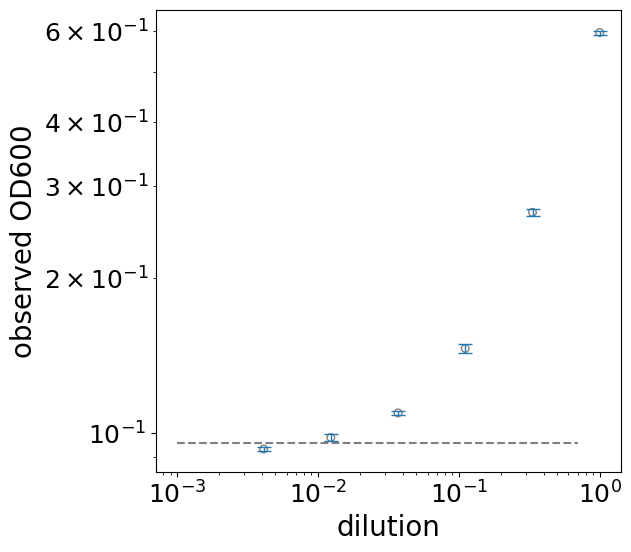

In [6]:
# Get mean and standard deviation from the rows
arr = tech_rep_df.to_numpy()
mu = np.mean(arr,axis=1)
std = np.std(arr,axis=1)

# Detection limit is midway between lowest and next-to-lowest point
od600_meas_threshold = (mu[-2] - mu[-1])/2 + mu[-1]

# Record the detection threshold in the calibration constants
CALIBRATION_CONSTANTS["OD600_MEAS_THRESHOLD"] = float(od600_meas_threshold)

# Print results
print(f"Detection threshold is: {od600_meas_threshold}")

# Create a plot
fig, ax = plt.subplots(1,figsize=(6,6))

ax.errorbar(x=tech_rep_df.index,
            y=mu,
            yerr=std,
            elinewidth=1,capsize=5,lw=0)
ax.scatter(x=tech_rep_df.index,
           y=mu,
           s=30,edgecolor="gray",facecolor="none")

ax.plot([0.001,0.7],[od600_meas_threshold,od600_meas_threshold],'--',color='gray')
ax.set_xlabel("dilution")
ax.set_ylabel("observed OD600")

ax.set_yscale('log')
ax.set_xscale('log')



### Characterize how the OD600 measurement uncertainty varies with OD600 value

OD600 average % error: 0.012540323503653895
OD600 max % error: 0.01964606679505892


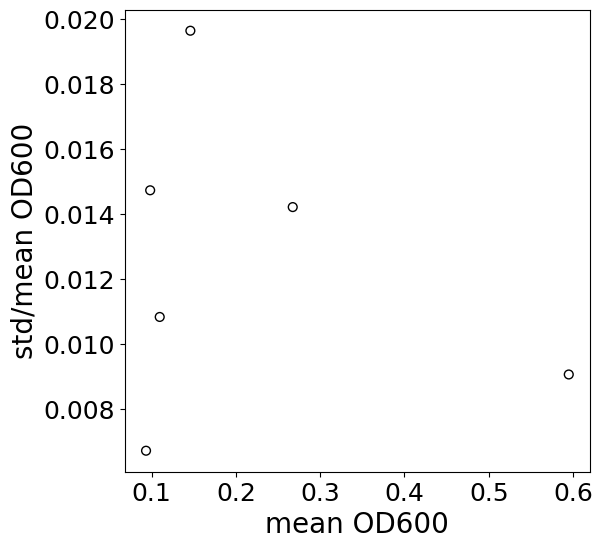

In [7]:
pct_err = std/mu # std/mu from previous cell

print(f"OD600 average % error: {np.mean(pct_err)}")
print(f"OD600 max % error: {np.max(pct_err)}") 

# Store the maximum pct error in OD600
CALIBRATION_CONSTANTS["OD600_PCT_STD"] = float(np.max(pct_err))

# Error in OD600 is linear in log(OD600). 
fig, ax = plt.subplots(1,figsize=(6,6))

# Plot 
ax.scatter(mu,pct_err,s=40,edgecolor="black",facecolor="none")
ax.set_xlabel("mean OD600")
ax.set_ylabel("std/mean OD600")
None


## Map OD600 to CFU/mL

### Extract estimate of cfu and cfu_std based on counting statistics and pietting error

In [8]:
# cfu (cfu*dilution)
cfu = pc_df["CFU"].to_numpy()*pc_df["Dilution"]

# cfu std (propagate counting and serial dilution uncertainty)
sigma2_counts = 1/pc_df["CFU"]
sigma2_dilution = (pc_df["num_dilutions"] + pc_df["plating_steps"])*(PIPETTE_PCT_ERROR**2)
cfu_std = cfu*np.sqrt(sigma2_counts + sigma2_dilution)

# od600
pc_df["od600"] = pc_df["OD600 plate reader"].to_numpy()
pc_df["od600_std"] = CALIBRATION_CONSTANTS["OD600_PCT_STD"]*(pc_df["od600"])
pc_df["cfu_per_mL"] = cfu
pc_df["cfu_per_mL_std"] = cfu_std

print(f"average cfu/mL percent error: {np.mean(pc_df['cfu_per_mL_std']/pc_df['cfu_per_mL'])}")


average cfu/mL percent error: 0.1031279987848501


#### Data to fit

We now have data to fit the relationship between od600 and cfu_per_mL, with standard errors on both od600 and cfu_per_mL. 

In [9]:
pc_df[["od600","od600_std","cfu_per_mL","cfu_per_mL_std"]]

,od600,od600_std,cfu_per_mL,cfu_per_mL_std
0,0.5880,0.011552,48500000,3.239660e+06
1,0.5299,0.010410,38500000,2.721654e+06
2,0.4499,0.008839,31500000,2.351893e+06
3,0.3857,0.007577,24400000,1.966943e+06
4,0.3386,0.006652,19800000,1.709063e+06
5,0.2941,0.005778,16100000,1.494023e+06
6,0.2588,0.005084,14600000,1.404131e+06
7,0.2267,0.004454,10100000,1.120189e+06
8,0.1830,0.003595,7500000,9.407444e+05
9,0.1680,0.003301,6800000,8.893683e+05


### Fit a polynomial to cfu/mL vs. OD600

Extract the polynomial here. We'll plot below

In [14]:
# Get polynomial relating od600_est to cfu_est and cfu_std

cfu = pc_df["cfu_per_mL"].to_numpy(dtype=float)
cfu_std = pc_df["cfu_per_mL_std"].to_numpy(dtype=float)
obs = pc_df["od600"].to_numpy(dtype=float)
params, param_std, cov_matrix, fit = run_least_squares(simple_poly,cfu,cfu_std,
                                                       [1,0,0], # <- guesses
                                                       args=(obs,))
print("cfu/mL vs od600 parameters")
print(params)


# Store calibration constants
CALIBRATION_CONSTANTS["A_CFU"] = float(params[0])
CALIBRATION_CONSTANTS["B_CFU"] = float(params[1])
CALIBRATION_CONSTANTS["C_CFU"] = float(params[2])


cfu/mL vs od600 parameters
[-5388603.36438282 66683325.953339   38292706.79524336]


### Fit a polynomial of cfu/mL error to OD600

Extract the polynomial here. We'll plot below

In [15]:

# Using covariance matrix, estimate cfu_pred_std --> the standard error on
# our predicted cfu/mL given the model
od600_smooth = np.linspace(np.min(pc_df["od600"])*0.95,np.max(pc_df["od600"])*1.05,20)
cfu_pred, cfu_pred_std = predict_with_error(simple_poly,
                                            params,
                                            cov_matrix,
                                            args=(od600_smooth,))

# Create a polynomial of cfu_pred_std vs. od600, allowing us to calculate 
# our cfu_pred_std given od600. 
err_params, _, err_cov_matrix, _ = run_least_squares(simple_poly,
                                                     cfu_pred_std,
                                                     np.full(len(cfu_pred),0.1e7),
                                                     [1,0,0],
                                                     args=(od600_smooth,))

print("JCpJ^T approximation parameters")
print(err_params)

CALIBRATION_CONSTANTS["P_JCJT_CFU"] = float(err_params[0])
CALIBRATION_CONSTANTS["Q_JCJT_CFU"] = float(err_params[1])
CALIBRATION_CONSTANTS["R_JCJT_CFU"] = float(err_params[2])


JCpJ^T approximation parameters
[  801108.73371897 -5133635.54769162 13418613.55590658]


## Final calibration constants 

In [16]:
with open(CALIBRATION_OUTPUT_FILE,'w') as f:
    yaml.dump(CALIBRATION_CONSTANTS,f)

CALIBRATION_CONSTANTS

{'OD600_MEAS_THRESHOLD': 0.09573000000000001,
 'OD600_PCT_STD': 0.01964606679505892,
 'A_CFU': -5388603.36438282,
 'B_CFU': 66683325.953339,
 'C_CFU': 38292706.79524336,
 'P_JCJT_CFU': 801108.7337189742,
 'Q_JCJT_CFU': -5133635.547691616,
 'R_JCJT_CFU': 13418613.55590658}

### Create a plot of results

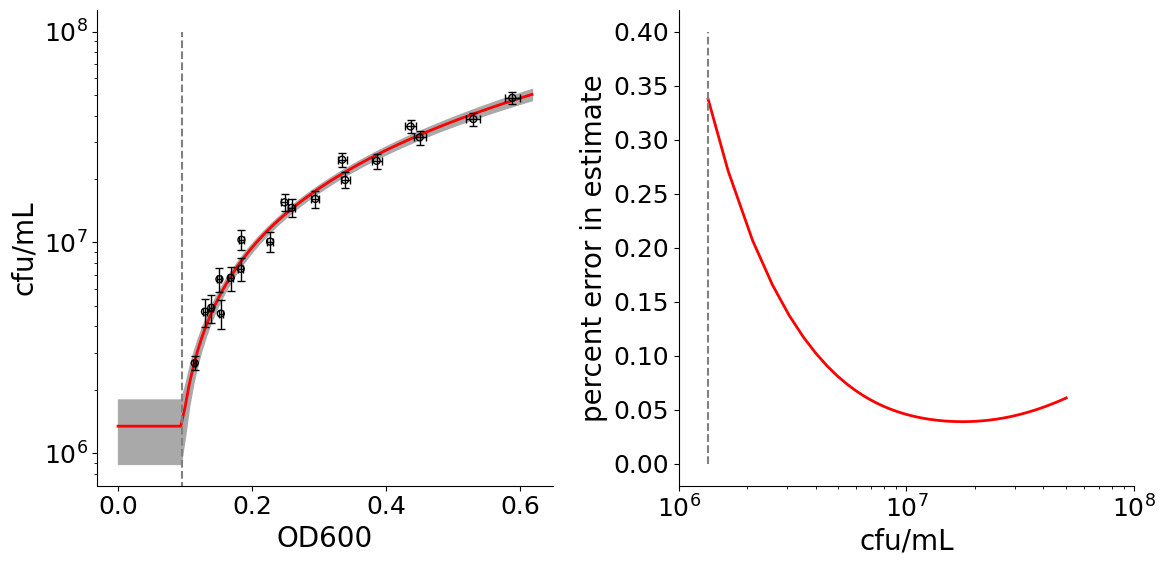

In [17]:


od600_smooth = np.linspace(0,np.max(pc_df["od600"])*1.05,100)
cfu_est_final, cfu_std_final, detectable = od600_to_cfu(od600_smooth,CALIBRATION_CONSTANTS)

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(pc_df["od600"], 
           pc_df["cfu_per_mL"], 
           s=25,facecolor='none',edgecolor='black',zorder=10)
ax[0].errorbar(x=pc_df["od600"], 
            xerr=pc_df["od600_std"],
            y=pc_df["cfu_per_mL"],
            yerr=pc_df["cfu_per_mL_std"],
            lw=0,capsize=3,color='black',elinewidth=1,zorder=10)

ax[0].plot(od600_smooth,cfu_est_final,'-',color='red',lw=2)
ax[0].fill_between(od600_smooth,
                cfu_est_final-cfu_std_final,
                cfu_est_final+cfu_std_final,
                color='darkgray',
                zorder=-3)
ax[0].plot([od600_meas_threshold,od600_meas_threshold],
        [0,1e8],'--',color='gray')

ax[0].set_xlabel("OD600")
ax[0].set_ylabel("cfu/mL")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_yscale("log")


min_detectable, _, _ = od600_to_cfu(0.09573000000000001,CALIBRATION_CONSTANTS)
ax[1].plot(cfu_est_final,cfu_std_final/cfu_est_final,lw=2,color='red')
ax[1].plot([min_detectable,min_detectable],[0,0.4],'--',color='gray')


ax[1].set_xlabel("cfu/mL")
ax[1].set_ylabel("percent error in estimate")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlim(1e6,1e8)
ax[1].set_xscale('log')

fig.tight_layout()
fig.savefig("calibration-results.png",transparent=True)
